**INITIALIZATION**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**LIBRARIES AND DEPENDENCIES**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [2]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [3]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
from fastbook import *                                  # Getting all the Libraries. 
from fastai.callback.fp16 import *
from fastai.vision.all import *                         # Getting all the Libraries.
#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

**PREPARING THE DATASET**

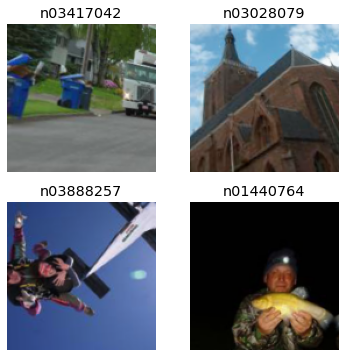

In [4]:
#@ FUNCTION FOR PREPARING THE DATASET:
def get_data(url, presize, resize):                                             # Defining Function. 
    path = untar_data(url)                                                      # Getting Path to the Dataset. 
    return DataBlock(blocks=(ImageBlock, CategoryBlock),                        # Initializing Data Blocks. 
                     get_items=get_image_files,                                 # Getting Image Files. 
                     splitter=GrandparentSplitter(valid_name="val"),            # Splitting the Dataset. 
                     get_y=parent_label, item_tfms=Resize(presize),             # Initializing Item Transformations. 
                     batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),   # Initializing Batch Transformations. 
                                 Normalize.from_stats(*imagenet_stats)],        # Normalizing the Dataset. 
                     ).dataloaders(path, bs=128)                                # Initializing Data Loaders. 

#@ INITIALIZING DATA LOADERS: 
dls = get_data(URLs.IMAGENETTE_160, 160, 128)                                   # Implementation of Function. 
dls.show_batch(max_n=4)                                                         # Inspecting the Data. 

**FULLY CONVOLUTIONAL NETWORKS**
- The idea in **Fully Convolutional Networks** is to take the average of activations across a convolutional grid. A **Fully Convolutional Networks** has a number of convolutional layers, some of which will be stride 2 convolutions at the end of which is an adaptive average pooling layer, a flatten layer to remove the unit axis and finally a linear layer. 

In [5]:
#@ FULLY CONVOLUTIONAL NEURAL NETWORKS: BASELINE MODEL: 
def block(ni, nf): return ConvLayer(ni, nf, stride=2)        # Defining Convolutional Layer. 
def get_model():                                             # Defining Fully Convolutional Network.             
    return nn.Sequential(block(3, 16),                       # Initializing Convolutional Layer. 
                         block(16, 32),                      # Initializing Convolutional Layer. 
                         block(32, 64),                      # Initializing Convolutional Layer. 
                         block(64, 128),                     # Initializing Convolutional Layer. 
                         block(128, 256),                    # Initializing Convolutional Layer. 
                         nn.AdaptiveAvgPool2d(1),            # Initializing Adaptive Average Pooling Layer. 
                         Flatten(),                          # Removing Unit Axis. 
                         nn.Linear(256, dls.c))              # Initializing Final Linear Layer. 

SuggestedLRs(valley=0.0003311311302240938)

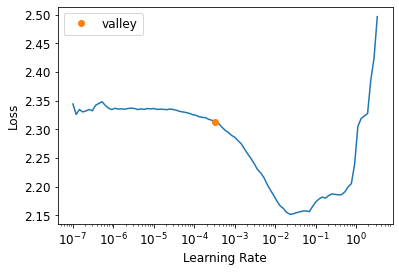

In [6]:
#@ FUNCTION FOR TRAINING THE MODEL: 
def get_learner(m):                                          # Defining the Function. 
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), 
                   metrics=accuracy).to_fp16()               # Initializing Learner.

#@ IMPLEMENTATION OF FUNCTION: 
learn = get_learner(get_model())                             # Initializing the Learner. 
learn.lr_find()                                              # Getting Optimal Learning Rate. 

In [7]:
#@ TRAINING THE MODEL: 
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.884642,2.062183,0.362293,00:34
1,1.538538,1.338052,0.565860,00:35
2,1.290522,1.416948,0.549045,00:34
3,1.131268,1.074217,0.660892,00:35
4,1.044464,1.053129,0.667771,00:35


**IDENTITY MAPPING**
- **Identity Mapping** is the process of returning the input without changing it at all which is performed by the identity function. 

**RESIDUAL NETWORKS: RESNETS**

In [8]:
#@ DEFINING RESNET BLOCK: BASELINE: 
class ResBlock(Module):                                               # Defining ResNet Block. 
    def __init__(self, ni, nf):                                       # Initializing Constructor Function. 
        self.convs = nn.Sequential(                                   # Initializing Sequential Model. 
            ConvLayer(ni, nf),                                        # Initializing Convolutional Layer. 
            ConvLayer(nf, nf, norm_type=NormType.BatchZero))          # Initializing Gamma to Zero of Batchnorm Layer. 
    
    def forward(self, x):                                             # Initializing Forward Propagation Function. 
        return x + self.convs(x)                                      # Initializing Skip Connection: Direct Input to Output. 

**Note:**
- The architecture defined above requires ni==nf. Incase of stride 2 convolutions, the input x and output activations will have different dimensions. 

In [9]:
#@ DEFINING RESNET BLOCK:
def _conv_block(ni, nf, stride):                                          # Defining Convolutions. 
    return nn.Sequential(                                                 # Initializing Sequential Model. 
        ConvLayer(ni, nf, stride=stride),                                 # Initializing Convolutional Layer. 
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))    # Gamma to Zero of Batchnorm: gamma*y + beta. 

class ResBlock(Module):                                                   # Defining ResNet Block. 
    def __init__(self, ni, nf, stride=1):                                 # Initializing Constructor Function. 
        self.convs = _conv_block(ni, nf, stride)                          # Implementation of Convolutions. 
        self.idconv = noop if ni==nf else ConvLayer(ni,nf,1,act_cls=None) # Initializing Identity Mapping. 
        self.pool = noop if stride==1 else nn.AvgPool2d(2,ceil_mode=True) # Initializing Average Pooling. 

    def forward(self, x):                                                 # Forward Propagation Function. 
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))          # Skip Connections: Direct Input to Output.

**Note:**
- I have used noop function here which simply returns its input unchanged which stands for no operation. Here, idconv does nothing when ni==nf and pool does nothing when stride==1 in **Skip Connections**. I have removed **RELU** from the final convolution using act_cls and moved it after the **Skip Connection**. 

In [10]:
#@ TRAINING THE MODEL:
def block(ni, nf):                                                        # Defining the Function. 
    return ResBlock(ni, nf, stride=2)                                     # Initializing ResNet Block. 
learn = get_learner(get_model())                                          # Initializing Learner. 
learn.fit_one_cycle(5, 3e-3)                                              # Training the Learner. 

epoch,train_loss,valid_loss,accuracy,time
0,1.956091,1.844275,0.354904,00:37
1,1.662141,1.497686,0.519490,00:36
2,1.375546,1.217079,0.616561,00:37
3,1.154046,1.098539,0.644586,00:37
4,1.027412,1.056631,0.667516,00:37


In [11]:
#@ TRAINING THE MODEL: DEEPER MODELS: 
def block(ni, nf):                                                        # Defining the Function. 
    return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))    # Initializing ResNet Block. 
learn = get_learner(get_model())                                          # Initializing Learner. 
learn.fit_one_cycle(5, 3e-3)                                              # Training the Learner. 

epoch,train_loss,valid_loss,accuracy,time
0,1.956257,1.991640,0.301656,00:40
1,1.625262,1.400524,0.540382,00:40
2,1.333224,1.175867,0.630573,00:39
3,1.071827,1.005912,0.670828,00:39
4,0.936459,0.921689,0.706752,00:39


**STATE OF ART RESNET**
- I will define the stem of the **ResNet** architecture which consist of convolutional layers followed by a max pooling layer. **Stem** is defined as the first few layers of **CNN**. It has different structure than the main body of CNN. 

In [13]:
#@ DEFINING THE STEAM OF RESNET: 
def _resnet_stem(*sizes):                                                 # Defining ResNet Stem Function. 
    return [ConvLayer(sizes[i], sizes[i+1], 3, stride=2 if i==0 else 1)   # Initializing Convolutional Layers. 
            for i in range(len(sizes)-1)] + \
            [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]            # Initializing Max Pooling Layer. 

#@ IMPLEMENTATION OF RESNET STEM: 
_resnet_stem(3, 32, 32, 64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]